In [1]:
using DrWatson
quickactivate(@__DIR__)
Base.LOAD_PATH .= findproject(@__DIR__);

import Baysor as B
import BaysorAnalysis as BA

import CairoMakie as MK
import Colors
import CSV
import Clustering
import Images
import MAT
import MultivariateStats
import Plots
import PlotThemes
import PyPlot as Plt
import Seaborn as Sns

using DataFrames
using DataFramesMeta
using NearestNeighbors
using ProgressMeter
using RCall
using SparseArrays
using Statistics
using StatsBase
using StatsPlots

ProgressMeter.ijulia_behavior(:clear);
MK.activate!(type = "png");
BA.set_pyplot_defaults!()
cplotsdir(args...) = plotsdir("benchmarking/stability", args...);

┌ Info: Precompiling BaysorAnalysis [1c155663-f2e3-5df5-a876-a2003b6282e9]
└ @ Base loading.jl:1317


In [3]:
using Distributed
addprocs(7)

@everywhere import Baysor as B
@everywhere import Clustering
@everywhere using StatsBase
@everywhere using Random
@everywhere using DataFrames

nprocs()

8

## Load data

In [4]:
SCALE = 6.5;
SCALE_STD = "25%";
MIN_MOLS_PER_CELL = 30;
NEW_COMP_FRAC = 0.3;
NEW_COMP_WEIGHT = 0.2;
N_ITERS = 400;
N_REPEATS = 7;

In [2]:
data = BA.load_merfish(pciseq=false);
df_spatial = @where(data[:df], :x .>= 6000, :x .<= 10000, :y .>= 6000, :y .<= 10000)
rename!(select!(df_spatial, Not([:x, :y, :z])), :x_raw => :x, :y_raw => :y)
size(df_spatial)

(251999, 11)

## Baseline runs

In [5]:
bm_data_init = B.initialize_bmm_data(df_spatial; scale=SCALE, scale_std=SCALE_STD, min_molecules_per_cell=MIN_MOLS_PER_CELL, confidence_nn_id=0);

┌ Info: Initializing algorithm. Scale: 6.5, scale std: 1.625, initial #components: 16798, #molecules: 251999.
└ @ Baysor /home/vpetukhov/.julia/dev/Baysor/src/data_processing/initialization.jl:235


In [6]:
@time baseline_assignments = pmap(1:N_REPEATS) do rep
    Random.seed!(rep + 1000)
    B.bmm!(deepcopy(bm_data_init); n_iters=N_ITERS, new_component_frac=NEW_COMP_FRAC, new_component_weight=NEW_COMP_WEIGHT,
        min_molecules_per_cell=MIN_MOLS_PER_CELL, assignment_history_depth=100, verbose=false).assignment
end;

417.416604 seconds (32.30 M allocations: 2.296 GiB, 0.44% gc time, 0.18% compilation time)


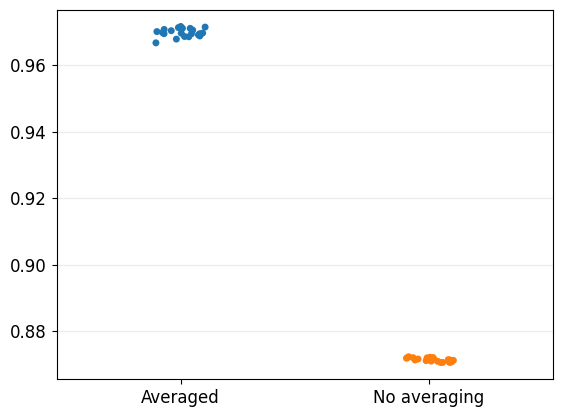

PyObject <AxesSubplot:>

In [135]:
p_vals = [Clustering.mutualinfo(baseline_assignments[i], baseline_assignments[j]) for i in 1:N_REPEATS for j in 1:N_REPEATS if i < j]
p_vals2 = [Clustering.mutualinfo(assignments_no_avg[i], assignments_no_avg[j]) for i in 1:N_REPEATS for j in 1:N_REPEATS if i < j]
Sns.stripplot(x=vcat(repeat(["Averaged"], length(p_vals)), repeat(["No averaging"], length(p_vals2))), y=vcat(p_vals, p_vals2))

In [7]:
@time assignments_no_avg = pmap(1:N_REPEATS) do rep
    Random.seed!(rep)
    B.bmm!(deepcopy(bm_data_init); n_iters=N_ITERS, new_component_frac=NEW_COMP_FRAC, new_component_weight=NEW_COMP_WEIGHT,
        min_molecules_per_cell=MIN_MOLS_PER_CELL, assignment_history_depth=0, verbose=false).assignment
end;

360.447716 seconds (162.18 k allocations: 24.587 MiB, 0.03% compilation time)


## Subsampling molecules

In [8]:
grid_size = 5
x_grid, y_grid = [floor.(Int, grid_size .* (df_spatial[!,c] .- minimum(df_spatial[!,c])) ./ (maximum(df_spatial[!,c]) - minimum(df_spatial[!,c]) .+ 0.01)) for c in [:x, :y]];
grid_labels = x_grid .+ grid_size .* y_grid .+ 1;
ids_per_grid = B.split_ids(grid_labels);

### Constant confidence

In [9]:
frac_vals = 0.1:0.1:1.0
subsamp_const_conf = []
prog = Progress(length(frac_vals))
for sub_frac in frac_vals
    sa_cur = pmap(1:N_REPEATS) do rep
        Random.seed!(rep)
        run_ids = vcat([(i % 2 == 0) ? ids : sample(ids, round(Int, length(ids) .* sub_frac); replace=false) for (i,ids) in enumerate(ids_per_grid)]...);
        bmd_init = B.initialize_bmm_data(df_spatial[run_ids,:]; scale=SCALE, scale_std=SCALE_STD, min_molecules_per_cell=MIN_MOLS_PER_CELL, 
            confidence_nn_id=0, verbose=false);
        bm_data = B.bmm!(deepcopy(bmd_init); n_iters=N_ITERS, new_component_frac=NEW_COMP_FRAC, new_component_weight=NEW_COMP_WEIGHT,
            min_molecules_per_cell=MIN_MOLS_PER_CELL, assignment_history_depth=100, verbose=false);
        return (run_ids, bm_data.assignment)
    end
    push!(subsamp_const_conf, sa_cur)
    next!(prog)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:44:43


### Updated confidences

In [10]:
subsamp_upd_conf = []
prog = Progress(length(frac_vals))
for sub_frac in frac_vals
    sa_cur = pmap(1:N_REPEATS) do rep
        Random.seed!(rep)
        run_ids = vcat([(i % 2 == 0) ? ids : sample(ids, round(Int, length(ids) .* sub_frac); replace=false) for (i,ids) in enumerate(ids_per_grid)]...);
        bmd_init = B.initialize_bmm_data(df_spatial[run_ids,:]; scale=SCALE, scale_std=SCALE_STD, min_molecules_per_cell=MIN_MOLS_PER_CELL, verbose=false);
        bm_data = B.bmm!(deepcopy(bmd_init); n_iters=N_ITERS, new_component_frac=NEW_COMP_FRAC, new_component_weight=NEW_COMP_WEIGHT,
            min_molecules_per_cell=MIN_MOLS_PER_CELL, assignment_history_depth=100, verbose=false);
        return (run_ids, bm_data.assignment)
    end
    push!(subsamp_upd_conf, sa_cur)
    next!(prog)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:42:57


### Visualization

In [11]:
is_grid_lab_subsampled = ((1:length(ids_per_grid)) .% 2 .!= 0);
is_mol_subsampled = is_grid_lab_subsampled[grid_labels];

In [12]:
@time agreement_df = vcat([vcat([DataFrame(Dict(
    :mi_subs => [Clustering.mutualinfo(ba[ids[is_mol_subsampled[ids]]], asn[is_mol_subsampled[ids]]) for (ids, asn) in sc for ba in baseline_assignments],
    :mi => [Clustering.mutualinfo(ba[ids[.!is_mol_subsampled[ids]]], asn[.!is_mol_subsampled[ids]]) for (ids, asn) in sc for ba in baseline_assignments],
    :ari_subs => [Clustering.randindex(ba[ids[is_mol_subsampled[ids]]], asn[is_mol_subsampled[ids]])[1] for (ids, asn) in sc for ba in baseline_assignments],
    :ari => [Clustering.randindex(ba[ids[.!is_mol_subsampled[ids]]], asn[.!is_mol_subsampled[ids]])[1] for (ids, asn) in sc for ba in baseline_assignments],
    :frac => frac,
    :type => tp
)) for (sc,frac) in zip(sct, frac_vals)]...) for (tp,sct) in [:const => subsamp_const_conf, :updated => subsamp_upd_conf]]...);

 19.886271 seconds (6.47 M allocations: 35.941 GiB, 4.48% gc time, 8.63% compilation time)


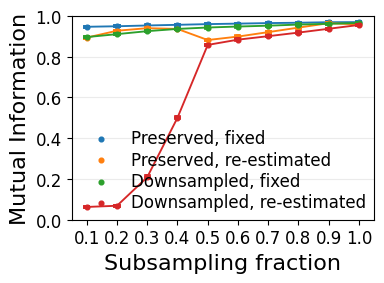

In [35]:
p_df = deepcopy(stack(agreement_df, [:mi, :mi_subs], [:frac, :type]));
p_df[!,:variable] = ifelse.(p_df.variable .== "mi", "Preserved", "Downsampled") .* ifelse.(p_df.type .== :const, ", fixed", ", re-estimated");

Plt.figure(figsize=(4,3))
Sns.pointplot(x=p_df.frac, y=p_df.value, hue=p_df.variable, capsize=0.1, lw=1, scale=0.5)
Plt.ylabel("Mutual Information"); Plt.xlabel("Subsampling fraction");
Plt.legend(loc="lower right", labelspacing=0.2)
Plt.ylim(0.0, 1.0);
Plt.tight_layout();

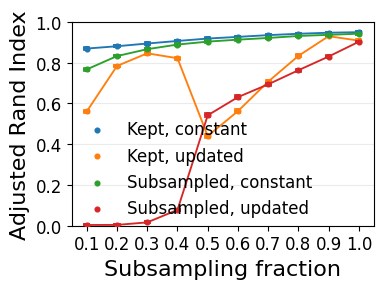

In [14]:
p_df = deepcopy(stack(agreement_df, [:ari, :ari_subs], [:frac, :type]));
p_df[!,:variable] = ifelse.(p_df.variable .== "ari", "Kept", "Subsampled") .* ifelse.(p_df.type .== :const, ", constant", ", updated");

Plt.figure(figsize=(4,3))
Sns.pointplot(x=p_df.frac, y=p_df.value, hue=p_df.variable, capsize=0.1, lw=1, scale=0.5)
Plt.ylabel("Adjusted Rand Index"); Plt.xlabel("Subsampling fraction");
Plt.ylim(0.0, 1.0);
Plt.tight_layout();

## Changing parameters

### MRF strength

In [15]:
mrf_strength_vals = [0.0, 0.05, 0.1, 0.5, 1.0, 5.0]
mrf_strength_assignments = []
prog = Progress(length(mrf_strength_vals))
for ms in mrf_strength_vals
    a_cur = pmap(1:N_REPEATS) do rep
        Random.seed!(rep)
        bm_data = deepcopy(bm_data_init);
        bm_data.mrf_strength = ms
        B.bmm!(bm_data; n_iters=N_ITERS, new_component_frac=NEW_COMP_FRAC, new_component_weight=NEW_COMP_WEIGHT,
            min_molecules_per_cell=MIN_MOLS_PER_CELL, assignment_history_depth=100, verbose=false);
        return bm_data.assignment
    end
    push!(mrf_strength_assignments, a_cur)
    next!(prog)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:38:28


### New component weight

In [36]:
new_comp_weight_vals = vcat(0.001, 0.2:0.2:1.0)
new_comp_weight_assignments = []
prog = Progress(length(new_comp_weight_vals))
for ncw in new_comp_weight_vals
    a_cur = pmap(1:N_REPEATS) do rep
        Random.seed!(rep)
        return B.bmm!(deepcopy(bm_data_init); n_iters=N_ITERS, new_component_frac=NEW_COMP_FRAC, new_component_weight=ncw,
            min_molecules_per_cell=MIN_MOLS_PER_CELL, assignment_history_depth=100, verbose=false).assignment
    end
    push!(new_comp_weight_assignments, a_cur)
    next!(prog)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:39:13


### New component frac

In [17]:
new_comp_frac_vals = 0.0:0.2:1.0
new_comp_frac_assignments = []
prog = Progress(length(new_comp_frac_vals))
for ncf in new_comp_frac_vals
    a_cur = pmap(1:N_REPEATS) do rep
        Random.seed!(rep)
        return B.bmm!(deepcopy(bm_data_init); n_iters=N_ITERS, new_component_frac=ncf, new_component_weight=NEW_COMP_WEIGHT,
            min_molecules_per_cell=MIN_MOLS_PER_CELL, assignment_history_depth=100, verbose=false).assignment
    end
    push!(new_comp_frac_assignments, a_cur)
    next!(prog)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:32:59


### Scale

In [18]:
scale_vals = 5:0.5:8
scale_assignments = []
prog = Progress(length(scale_vals))
for sc in scale_vals
    a_cur = pmap(1:N_REPEATS) do rep
        Random.seed!(rep)
        bmd_init = B.initialize_bmm_data(df_spatial; scale=sc, scale_std=SCALE_STD, min_molecules_per_cell=MIN_MOLS_PER_CELL, verbose=false);
        return B.bmm!(bmd_init; n_iters=N_ITERS, new_component_frac=NEW_COMP_FRAC, new_component_weight=NEW_COMP_WEIGHT,
            min_molecules_per_cell=MIN_MOLS_PER_CELL, assignment_history_depth=100, verbose=false).assignment
    end
    push!(scale_assignments, a_cur)
    next!(prog)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:37:59


### Scale Std

In [19]:
scale_std_vals = ["$(s)%" for s in 10:15:100]
scale_std_assignments = []
prog = Progress(length(scale_std_vals))
for ss in scale_std_vals
    a_cur = pmap(1:N_REPEATS) do rep
        Random.seed!(rep)
        bmd_init = B.initialize_bmm_data(df_spatial; scale=SCALE, scale_std=ss, min_molecules_per_cell=MIN_MOLS_PER_CELL, verbose=false);
        return B.bmm!(bmd_init; n_iters=N_ITERS, new_component_frac=NEW_COMP_FRAC, new_component_weight=NEW_COMP_WEIGHT,
            min_molecules_per_cell=MIN_MOLS_PER_CELL, assignment_history_depth=100, verbose=false).assignment
    end
    push!(scale_std_assignments, a_cur)
    next!(prog)
end

Progress: 100%|█████████████████████████████████████████| Time: 0:38:44


### Min. molecules per cell

Constant confidence:

In [20]:
min_mol_vals = vcat(1, 10:10:100)
min_mol_assignments_const_conf = []
prog = Progress(length(min_mol_vals))
for mm in min_mol_vals
    a_cur = pmap(1:N_REPEATS) do rep
        Random.seed!(rep)
        bmd_init = B.initialize_bmm_data(df_spatial; scale=SCALE, scale_std=SCALE_STD, min_molecules_per_cell=mm, confidence_nn_id=0, verbose=false);
        return B.bmm!(bmd_init; n_iters=N_ITERS, new_component_frac=NEW_COMP_FRAC, new_component_weight=NEW_COMP_WEIGHT,
            min_molecules_per_cell=mm, assignment_history_depth=100, verbose=false).assignment
    end
    push!(min_mol_assignments_const_conf, a_cur)
    next!(prog)
end

Progress: 100%|█████████████████████████████████████████| Time: 1:00:11


Re-estimate confidence:

In [21]:
min_mol_assignments = []
prog = Progress(length(min_mol_vals))
for mm in min_mol_vals
    a_cur = pmap(1:N_REPEATS) do rep
        Random.seed!(rep)
        bmd_init = B.initialize_bmm_data(df_spatial; scale=SCALE, scale_std=SCALE_STD, min_molecules_per_cell=mm, verbose=false);
        return B.bmm!(bmd_init; n_iters=N_ITERS, new_component_frac=NEW_COMP_FRAC, new_component_weight=NEW_COMP_WEIGHT,
            min_molecules_per_cell=mm, assignment_history_depth=100, verbose=false).assignment
    end
    push!(min_mol_assignments, a_cur)
    next!(prog)
end

Progress: 100%|█████████████████████████████████████████| Time: 1:00:18


## Visualization

In [22]:
param_combs = [
    ("MRF strength (β)", mrf_strength_assignments, mrf_strength_vals),
    ("New component weight (α)", new_comp_weight_assignments, new_comp_weight_vals),
    ("New component frac.", new_comp_frac_assignments, new_comp_frac_vals),
    ("Scale", scale_assignments, scale_vals),
    ("Scale std", scale_std_assignments, scale_std_vals),
    ("Min. molecules per cell", min_mol_assignments, min_mol_vals),
    ("Min. molecules per cell,\nfixed confidence", min_mol_assignments_const_conf, min_mol_vals)
];

In [33]:
# B.plot_molecules(df_spatial, color=B.shuffle_colors(min_mol_assignments[4][1]), markersize=1, axis_kwargs=(xticklabelsvisible=true, yticklabelsvisible=true))

In [25]:
@time param_agreement_dfs = Dict(k => vcat(progress_pmap(
    (asns,p) -> begin DataFrame(Dict(
    :mi => [Clustering.mutualinfo(ba, asn) for asn in asns for ba in baseline_assignments],
    :ari => [Clustering.randindex(ba, asn)[1] for asn in asns for ba in baseline_assignments],
    :param => p
)) end, assignments, param_vals)...) for (k, assignments, param_vals) in param_combs);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:01
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


 26.498592 seconds (10.58 M allocations: 675.546 MiB, 0.63% gc time, 6.65% compilation time)


In [48]:
import JLD
JLD.jldopen(projectdir("cache/param_agreement_dfs.jld"), "w") do file
    write(file, "param_agreement_dfs", param_agreement_dfs)
    write(file, "agreement_df", agreement_df)
end;

In [101]:
mm_df = vcat(@transform(param_agreement_dfs["Min. molecules per cell"], t="Re-estimated"), 
    @transform(param_agreement_dfs["Min. molecules per cell,\nfixed confidence"], t="Fixed"));

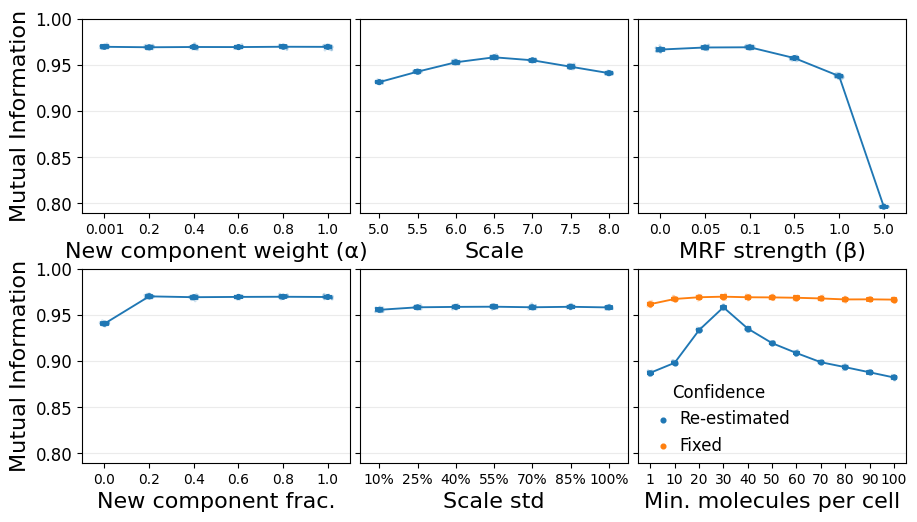

In [226]:
fig, axes = Plt.subplots(2, 3, figsize=(9, 5), sharey=true);
plot_order = ["New component weight (α)", "New component frac.", "Scale", "Scale std", "MRF strength (β)"]
for (k,ax) in zip(plot_order, axes[1:5])
    df = param_agreement_dfs[k]
    Sns.stripplot(x=df.param, y=df.mi, hue=ones(Int, length(df.mi)), size=2, alpha=0.2, ax=ax)
    Sns.pointplot(x=df.param, y=df.mi, capsize=0.1, lw=1, scale=0.5, ax=ax)
    ax.legend([], [])
    ax.set_xlabel(k);
    ax.set_ylim(0.79, 1.0)
end

for ax in axes[1:2]
    ax.set_ylabel("Mutual Information")
end

Sns.pointplot(x=mm_df.param, y=mm_df.mi, hue=mm_df.t, capsize=0.1, lw=1, scale=0.5, ax=axes[6])
hn, lb = axes[6].get_legend_handles_labels()
Sns.stripplot(x=mm_df.param, y=mm_df.mi, hue=mm_df.t, size=2, alpha=0.2, ax=axes[6])
axes[6].legend(hn, lb, title="Confidence", handletextpad=0.0)
axes[6].set_xlabel("Min. molecules per cell")

for ax in axes
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=10)
end

Plt.tight_layout(pad=0);
Plt.savefig(plotsdir("benchmarking/parameter_sensitivity.pdf"), transparent=true)

CSVs below are produced in the *stability.ipynb* notebook

In [173]:
df_paths = projectdir.("cache", ["stability_df_merfish.csv", "stability_df_iss.csv", "stability_df_osm.csv", "stability_df_starmap.csv"])
stability_df = @where(vcat(CSV.read.(df_paths, DataFrame)...), :Metric .== "Mutual Information");

  0.138577 seconds (110.94 k allocations: 6.974 MiB, 98.34% compilation time)


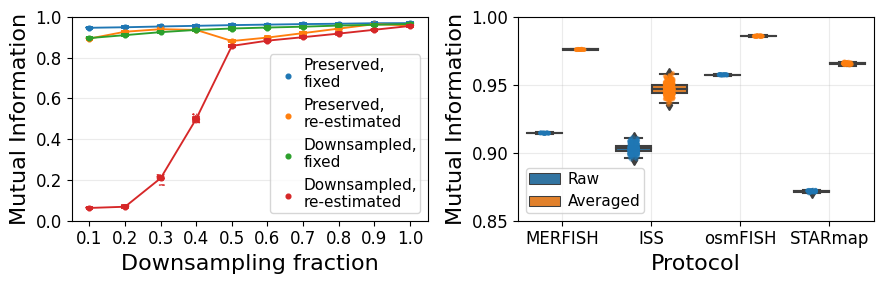

In [229]:
fig, (ax_sparsity, ax_stability) = Plt.subplots(1, 2, figsize=(9, 3))
p_df = deepcopy(stack(agreement_df, [:mi, :mi_subs], [:frac, :type]));
p_df[!,:variable] = ifelse.(p_df.variable .== "mi", "Preserved", "Downsampled") .* ",\n" .* ifelse.(p_df.type .== :const, "fixed", "re-estimated");
Sns.pointplot(x=p_df.frac, y=p_df.value, hue=p_df.variable, capsize=0.1, lw=1, scale=0.5, ax=ax_sparsity)
hn, lb = ax_sparsity.get_legend_handles_labels()
Sns.stripplot(x=p_df.frac, y=p_df.value, hue=p_df.variable, ax=ax_sparsity, s=1, rasterized=true)

ax_sparsity.legend(hn, lb, loc="lower right", labelspacing=0.5, fontsize=11, frameon=true, handletextpad=0, borderpad=0.2)
ax_sparsity.set_ylabel("Mutual Information"); ax_sparsity.set_xlabel("Downsampling fraction")
ax_sparsity.set_ylim(0, 1);

Sns.boxplot(x=stability_df.Protocol, y=stability_df.Value, hue=stability_df.Type, ax=ax_stability)
hn, lb = ax_stability.get_legend_handles_labels()
Sns.stripplot(x=stability_df.Protocol, y=stability_df.Value, hue=stability_df.Type, dodge=true, s=3, alpha=0.5, ax=ax_stability, rasterized=true)
ax_stability.grid(true)
ax_stability.legend(hn, lb, loc="lower left", fontsize=11, frameon=true, handletextpad=0.5, borderpad=0.25)
ax_stability.set_ylim(0.85, 1.0)
ax_stability.set_ylabel("Mutual Information"); ax_stability.set_xlabel("Protocol")
Plt.tight_layout()
Plt.savefig(plotsdir("benchmarking/sparsity_and_avg_sensitivity.pdf"), transparent=true)